In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

In [2]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    classif=np.unique(y)
    fullmat=np.concatenate((X,y),axis=1)
    means=np.zeros((np.size(X,axis=1),np.size(classif)))
    covmat=np.zeros((np.size(X,axis=1),np.size(X,axis=1)))

    for k in range(np.size(classif)):
        for d in range(np.size(X,axis=1)):
            means[d,k]=np.mean(fullmat[np.where(np.array(y)==classif[k])[0],d])
      
    for i in range(np.size(X,axis=1)):
        for j in range(np.size(X,axis=1)):
            imean=np.mean(X[:,i])
            jmean=np.mean(X[:,j])
            covmat[i,j]=np.sum(np.multiply((X[:,i]-imean),(X[:,j]-jmean)))/(np.size(X,axis=0))

    return means,covmat

In [3]:
def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    classif=np.unique(np.array(y))
    fullmat=np.concatenate((X,y),axis=1)
    means=np.zeros((np.size(X,axis=1),np.size(classif)))
    covmats=list()

    for k in range(np.size(classif)):
        for d in range(np.size(X,axis=1)):
            means[d,k]=np.mean(fullmat[np.where(np.array(y)==classif[k])[0],d])
                    
        classmat=fullmat[np.where(np.array(y)==classif[k])[0],:-1]

        covmatd=np.zeros((np.size(classmat,axis=1),np.size(classmat,axis=1)))
        for i in range(np.size(classmat,axis=1)):
            for j in range(np.size(classmat,axis=1)):
                imean=np.mean(classmat[:,i])
                jmean=np.mean(classmat[:,j])
                covmatd[i,j]=np.sum(np.multiply((classmat[:,i]-imean),(classmat[:,j]-jmean)))/(np.size(classmat,axis=0))
        
        covmats.append(covmatd)
        
    return means,covmats

In [4]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    cprior=1/np.size(means,axis=1)
    
    probc=np.zeros((np.size(Xtest,axis=0),np.size(means,axis=1)))
    for c in range(np.size(means,axis=1)):
        gc=-1/2*(np.matmul(np.matmul(means[:,[c]].T,inv(covmat)),means[:,[c]]))+np.log(cprior)
        betac=np.matmul(inv(covmat),means[:,[c]])
        probc[:,[c]]=(betac.T @ Xtest.T+gc).T
        
    ypred=np.argmax(probc,axis=1)
    ypred=ypred+1  #as index starts here from 0 for true label so augmenting by 1
    acc=np.mean(ypred==ytest.T)
        
    return acc,ypred

In [5]:
def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    cprior=1/np.size(means,axis=1)
    
    probc=np.zeros((np.size(Xtest,axis=0),np.size(means,axis=1)))
    
    for irow in range(Xtest.shape[0]):
        Xrow=Xtest[irow,:]
        Xrow=Xrow.reshape(Xrow.shape[0],1)
        for c in range(np.size(means,axis=1)):
            logcov=-1/2 * np.log(det((covmats[c])))
            centX=Xrow-means[:,[c]]
            invcov=inv(covmats[c])
            probc[irow,[c]]=(logcov- 1/2*(centX.T @ invcov @ centX)+np.log(cprior))
        
    ypred=np.argmax(probc,axis=1)
    ypred=ypred+1  #as index starts here from 0 for true label so augmenting by 1
    acc=np.mean(ypred==ytest.T)

    return acc,ypred

In [6]:
def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 
    w=inv(X.T @ X) @ X.T @ y
    return w

In [7]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                
        
    I=np.identity(np.size(X,axis=1))
                                            
    w=inv(X.T @ X + lambd*I) @ X.T @ y

    return w

In [8]:
def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse
    
    ypred=Xtest @ w
    mse=np.mean(np.power((ytest-ypred),2))
    return mse

In [9]:
def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda
    
    #Reshaping as per the Xw and Y column vector to find error
    w=w.T
    w=w.reshape(len(w),1)
    y=y.reshape(y.shape[0],1)
    
    Xw=X @ w
        
    error = (1/2)*((Xw-y).T @ (Xw-y))+(1/2)*lambd*np.dot(w.T, w)
    error_grad= X.T @ Xw - X.T @ y+lambd*w
    
    return error, error_grad.flatten()

In [10]:
def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xp - (N x (p+1)) 
    
    Xp=np.ones((np.size(x,axis=0),1))
    
    for i in range(1,p+1):
        Xp=np.hstack((Xp,np.power(x,i).reshape((x.shape[0],1))))
        
    return Xp


LDA Accuracy = 0.97
QDA Accuracy = 0.96


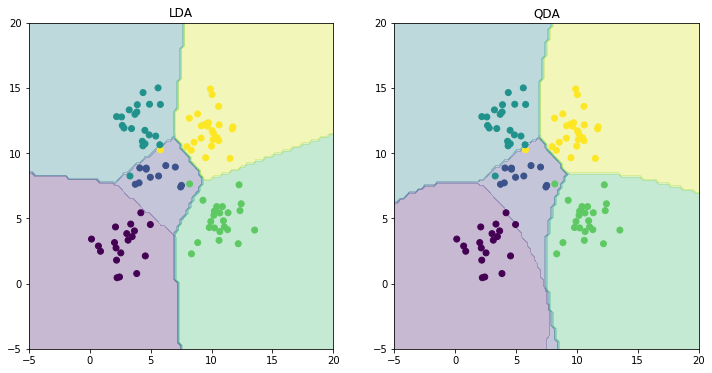

In [11]:
# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.ravel())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.ravel())
plt.title('QDA')

plt.show()

In [12]:
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle= testOLERegression(w,X,y)
mlet = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i= testOLERegression(w_i,X_i,y)
mle_it = testOLERegression(w_i,Xtest_i,ytest)

print('-------------------------------------------------------------------')

print('MSE without intercept train data  :'+str(mle))
print('MSE with intercept train data     :'+str(mle_i))

print('MSE without intercept test data   :'+str(mlet))
print('MSE with intercept test data      :'+str(mle_it))

print('-------------------------------------------------------------------')

-------------------------------------------------------------------
MSE without intercept train data  :19099.44684457055
MSE with intercept train data     :2187.1602949303892
MSE without intercept test data   :106775.36155354623
MSE with intercept test data      :3707.8401817711774
-------------------------------------------------------------------


--------------Lambda for which the MSE is minimum for the test data------------------
1. Lambda value   2. Weight for the lambda   3.Training data MSE   4.Test Data MSE
-------------------------------------------------------------------------------------
[[[0.06
   array([[ 150.45959807],
       [   4.80776899],
       [-202.90611468],
       [ 421.7194576 ],
       [ 279.45107288],
       [ -52.29708233],
       [-128.59418907],
       [-167.50057028],
       [ 145.74068096],
       [ 496.30604123],
       [ 129.94845775],
       [  88.30438076],
       [  11.29067689],
       [   1.88532531],
       [  -2.58364157],
       [ -66.89445481],
       [ -20.61939955],
       [ 113.39301454],
       [  17.99086827],
       [  52.50235963],
       [ 109.68765513],
       [ -10.72779629],
       [  71.67974829],
       [ -69.30906366],
       [-124.03437293],
       [ 102.63981795],
       [  72.64220588],
       [  79.24754013],
       [  38.48319215],
       [  32.98009446],
       [  92.0

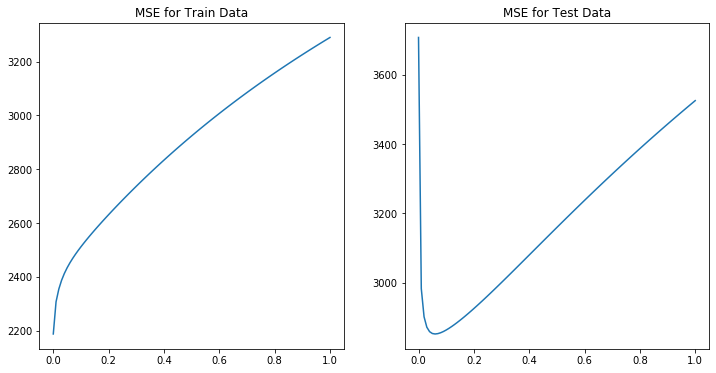

In [13]:
# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
ridgeeach = np.empty((0,4), object)

for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    ridgeeach=np.append(ridgeeach,np.array([[lambd,w_l,mses3_train[i],mses3[i]]]), axis=0)
    i = i + 1
            
print('--------------Lambda for which the MSE is minimum for the test data------------------')
print('1. Lambda value   2. Weight for the lambda   3.Training data MSE   4.Test Data MSE')
print('-------------------------------------------------------------------------------------') 
print(ridgeeach[np.where(ridgeeach[:,3]<=min(ridgeeach[:,3])),:])
print('-------------------------------------------------------------------------------------')            
    
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

--------Gradient Descent Lambda for which the MSE is minimum for the test data-------
1. Lambda value   2. Weight for the lambda   3.Training data MSE   4.Test Data MSE
-------------------------------------------------------------------------------------
[[[0.07
   array([[ 1.50557288e+02],
       [ 4.87412916e+00],
       [-2.03022212e+02],
       [ 4.28147867e+02],
       [ 2.80877959e+02],
       [-4.61484152e+01],
       [-1.26460198e+02],
       [-1.72074996e+02],
       [ 1.41892746e+02],
       [ 4.87134121e+02],
       [ 1.17889366e+02],
       [ 8.17992420e+01],
       [ 8.72731244e+00],
       [-5.17186551e+00],
       [ 1.48168374e+00],
       [-6.48372867e+01],
       [-3.19972265e-01],
       [ 9.20447701e+01],
       [-1.39733099e+01],
       [ 5.00456303e+01],
       [ 1.10536432e+02],
       [-7.01347067e+00],
       [ 6.85325790e+01],
       [-5.71154647e+01],
       [-1.16099095e+02],
       [ 8.16121844e+01],
       [ 4.24177205e+01],
       [ 8.15997327e+01],
      

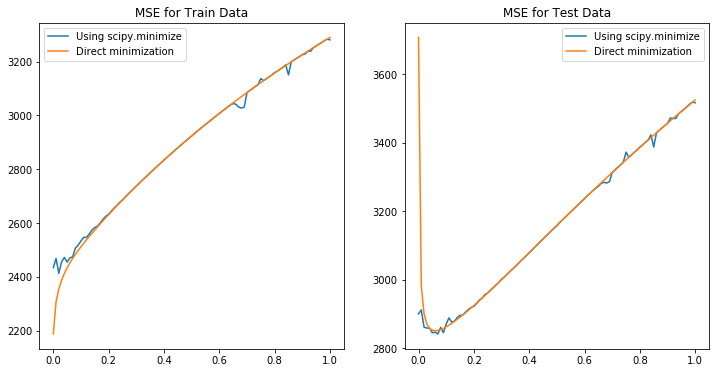

In [14]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
gradientridgeeach = np.empty((0,4), object)

for lambd in lambdas:
    args = (X_i, y.flatten(), lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    gradientridgeeach=np.append(gradientridgeeach,np.array([[lambd,w_l,mses4_train[i],mses4[i]]]), axis=0)
    i = i + 1

    
print('--------Gradient Descent Lambda for which the MSE is minimum for the test data-------')
print('1. Lambda value   2. Weight for the lambda   3.Training data MSE   4.Test Data MSE')
print('-------------------------------------------------------------------------------------') 
print(gradientridgeeach[np.where(gradientridgeeach[:,3]<=min(gradientridgeeach[:,3])),:])
print('-------------------------------------------------------------------------------------')  

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()


--------Non-Linear with optimal Lambda for which the MSE is minimum for the test data-------
1. P value   2. Weight for the lambda   3.Training data MSE   4.Test Data MSE
-------------------------------------------------------------------------------------
[[[4
   array([[1.51054850e+02],
       [8.24176598e+02],
       [5.33569136e+01],
       [5.58662692e+00],
       [7.24511083e-01]])
   3950.682336795369 3895.582668283526]]]
-------------------------------------------------------------------------------------


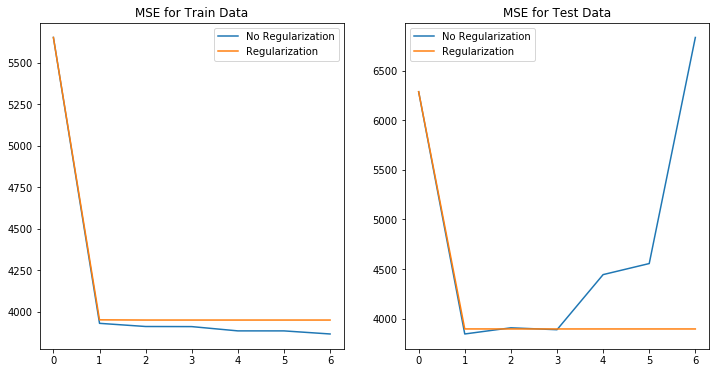

In [15]:
# Problem 5
pmax = 7
lambda_opt = 0.06 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
nonlinridgeeach = np.empty((0,4), object)

for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)
    nonlinridgeeach=np.append(nonlinridgeeach,np.array([[p,w_d2,mses5_train[p,1],mses5[p,1]]]), axis=0)

print('--------Non-Linear with optimal Lambda for which the MSE is minimum for the test data-------')
print('1. P value   2. Weight for the lambda   3.Training data MSE   4.Test Data MSE')
print('-------------------------------------------------------------------------------------') 
print(nonlinridgeeach[np.where(nonlinridgeeach[:,3]<=min(nonlinridgeeach[:,3])),:])
print('-------------------------------------------------------------------------------------') 


    
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()